<a href="https://colab.research.google.com/github/nedokormysh/NLP_Fontanka/blob/main/Pymagic_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install natasha -q
!pip install catboost -q
# !pip install evaluate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 53.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.4 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd
import datetime

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

from catboost import CatBoostClassifier

from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import gensim.downloader
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.fasttext import FastText
from natasha import Doc, Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, \
                       LabelEncoder, label_binarize
# from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
    precision_score, recall_score, f1_score, roc_auc_score, log_loss, auc,\
    roc_curve, confusion_matrix, ConfusionMatrixDisplay

from typing import List, Optional, Tuple, Union

import pickle

sns.set(style="darkgrid")
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
RND_STATE = 7575

# Загрузка данных

Загрузка и логика обработки были рассмотрены в ноутбуке EDA. Хотим решать задачу классификации текстов по темам.

Предположим бизнес-задачу: **тэгирование текстов**.


In [ ]:
df = pd.read_csv('/content/df_prepared.csv')

In [ ]:
df.sample(3)

,content,topic,comments_amount,len_title,len_content,year,month,weekday,hour,log_views,log_views_by_minutes
44134,Трое росгвардейцев пострадали при взрыве на по...,происшествия,10,79,406,2023,December,Thursday,16,8.983691,0.032825
25461,На рынке первичного жилья Нижнего Новгорода на...,строительство,2,99,1430,2023,February,Thursday,17,7.630947,0.003107
37276,"В российских школах, колледжах и техникумах на...",общество,16,78,1031,2023,August,Wednesday,16,7.700748,0.005629


# Преобработка текстов

У нас есть необработанные тексты.

В чистом виде тексты можно подавать в модель Catboost. В другие модели нам потребуется обрабатывать статьи.

- разобьём предложение на токены при помощи библиотеки natasha
- лемматизируем слова при помощи библиотеки natasha
- отфильтруем стоп-слова. Возьмём их из библиотеки nltk и добавим несколько своих
- соберём тексты вновь
- добавим предобработанные тексты в наш датасет

In [ ]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

In [ ]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так',
                    'вот', 'быть', 'как',
                    'в', '—', 'к', 'за', 'из', 'из-за',
                    'на', 'ок', 'кстати',
                    'который', 'мочь', 'весь',
                    'еще', 'также', 'свой',
                    'ещё', 'самый', 'ул', 'комментарий',
                    'английский', 'язык'])

In [ ]:
def text_prep(text: str) -> str:
    """
    Функция предобработки текста: лемматизация, фильтрация от стоп-слов

    :param text: строка текста
    :return: обработанная строка текста
    """
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    for token in doc.tokens:
        token.lemmatize(morph_vocab)

    lemmas = [_.lemma for _ in doc.tokens]
    words = [lemma for lemma in lemmas if lemma.isalpha() and len(lemma) > 2]
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

Применим функцию для текстов и заголовков

In [ ]:
%%time
df['content_clean'] = df.content.apply(text_prep)

CPU times: user 38min 30s, sys: 22min 38s, total: 1h 1min 9s
Wall time: 36min 47s


Пример содержания до и после обработки

In [ ]:
# Содержание
df.sample(1)[['content', 'content_clean']].values

array([['Месяц в следственном изоляторе предстоит провести продавцу круглосуточного магазина в Выборгском районе Петербурга, конфликт которого с посетительницей разлетелся по соцсетям и СМИ.Как сообщает объединённая пресс-служба судов города, 11 июля Выборгский районный суд удовлетворил ходатайство следствия и заключил Фаига Натига Фахрадова под стражу до пятого августа. Фахрадову вменяют причинение побоев (ст. 116 УК). Это преступление небольшой тяжести, «потолок» которой — два года лишения свободы. Причина его задержания попала на видео.  Согласно материалам дела, продавец магазина «5 копеек» на улице Шостаковича схватил девушку за шею, повалил на тротуар, сел сверху и придавил коленом к земле. Родные потерпевшей рассказали, что устали терпеть шум от работы магазина и вечером 6 июля пришли требовать тишины.  Одна из посетительниц сняла с двери колокольчик, вторая, как говорят знакомые обвиняемого, не сдерживаясь в выражениях, выговаривала Фахрадову. Уже на улице в ход якобы пошли оск

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45472 entries, 0 to 45471
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   content               45472 non-null  object 
 1   topic                 45472 non-null  object 
 2   comments_amount       45472 non-null  int64  
 3   len_title             45472 non-null  int64  
 4   len_content           45472 non-null  int64  
 5   year                  45472 non-null  int64  
 6   month                 45472 non-null  object 
 7   weekday               45472 non-null  object 
 8   hour                  45472 non-null  int64  
 9   log_views             45472 non-null  float64
 10  log_views_by_minutes  45472 non-null  float64
 11  content_clean         45472 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 4.2+ MB


In [ ]:
df.to_csv('df_preprocessed.csv', index=False)

# Вспомогательные функции и классы

- **Функция отрисовки результатов** на обучающем и тестовом датасете

In [4]:
# для отображения лейблов будем производить инвертирование в функции
def plot_confusion_matrix(y_true: np.ndarray,
                          X: pd.DataFrame,

                          ax: Optional[matplotlib.axes.Axes] = None,
                          model#: Optional[Union[sklearn.base.BaseEstimator,
                                                #  sklearn.pipeline.Pipeline]]
                          = None,
                          prediction: Optional[np.ndarray] = None,
                          cmap: str = 'Blues'):
    """Визуализация ConfusionMatrix
    :param y_true: массив с настоящими значениями целевой переменной
    :param X: датафрейм
    :param ax: область рисования на графике
    :param model: экземпляр класса модели
    :param prediction: массив с прогнозируемыми значениями
    :param cmap: строка для выбора цвета отрисовки графика
    """
    if prediction is None:
        prediction = model.predict(X)

    prediction_inversed = le.inverse_transform(prediction)
    y_true_inversed = le.inverse_transform(y_true)

    labels = list(set(prediction_inversed))

    cm_ovr = confusion_matrix(y_true_inversed,
                              prediction_inversed,
                              labels=labels)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_ovr,
                                  display_labels=labels)

    if ax:
        disp.plot(ax=ax, cmap=cmap)

- **Класс для выбора колонок**

У нас есть текстовые колонки: необработанный текст и текст после препроцессинга.
Хотим сравнить модели Catboost с использованием встроенной обработкой текстовых признаков и catboost, где текстовые признаки будем обрабатывать самостоятельно.
Для такого сравнения нам потребуется создавать 2 датасета, чего не хотелось бы допускать.

Кроме того из EDA мы знаем, часть сгенерированных признаков у нас имеет линейную зависимость, их можно удалить из полученного датасета, либо просто не использовать.

Пришлось создавать кастомный класс, т.к. написанные библиотеки чаще всего возвращают массивы, а не датасеты. И передать это всё в наши модели становится проблематично.

Поэтому поэтому написан класс, который позволяет выбрать какие колонки мы будем использовать, возвращает датасет. И этот датасет уже можно будет передавать дальше по пайплайну.

In [5]:
class CustomSelectColumns():
    """
    Класс выбора требуемых колонок
    """
    def __init__(self,
                 selected_feats: List[str] = None):
        """
        :param selected_feats: лист с выбранными признаками
        """
        self.sel_feats = selected_feats

    def fit(self,
            X: pd.DataFrame,
            y: pd.Series = None):
        """
        метод применения класса
        :param X: датасет
        :param y: целевая переменная
        :return: экземпляр класса CustomSelectColumns
        """
        return self

    def transform(self,
                  X: pd.DataFrame,
                  y: pd.Series = None) -> pd.DataFrame:
        """
        метод трансформации датасета
        :param X: датасет
        :param y: целевая переменная
        :return: изменённый датасет
        """
        X_ = X.copy()
        X_filtered = X_[self.sel_feats]
        X_filtered = pd.DataFrame(X_filtered)
        return pd.DataFrame(X_filtered)

- **Класс для трансформации колонок**

Будем трансформировать колонки: масштабировать численные переменные, категориальные кодировать, а текстовые либо создавать токены, либо не изменять (в зависимости какие текстовые колонки будем подавать на вход модели).

In [6]:
class CustomTransformer():
    """
    Класс трансформации признаков.
    Числовые данные нормализуются или стандартизируются.
    Категориальные признаки не изменяются.
    После трансформаци возвращается датафрейм.
    """
    def __init__(self,
                 scaler_type: Union[StandardScaler, MinMaxScaler] = None,
                 cat_feats: List[str] = ['month', 'weekday'],
                 txt_feats: List[str] = ['content'],
                 split: bool = False,
                 with_mean: bool = True,
                 with_std: bool = True,
                 feature_range: tuple[int, int]=(0, 1)) -> None:

        """
        :param scaler_type: экземпляр класса мастшабирования или стандартизации
        :param cat_feats: лист с категориальными признаками
        :param txt_feats: лист с текстовыми призаками
        :param split: логическая переменная разбивать строку на токены
        :param with_mean: логическая переменная StandardScaler
                          - вычитать среднее значение
        :param with_std: логическая переменная StandardScaler
                          - делить на стандартное отклоннение
        :param feature_range: параметр класса MinMaxScaler
                          - диапазоном значений, на который масштабируются
                          признаки
        """

        self.scaler_type = scaler_type
        if scaler_type:
            self.scaler = StandardScaler(with_mean=with_mean, with_std=with_std)
        else:
            self.scaler = MinMaxScaler(feature_range=feature_range)

        self.split = split

        self.cat_encoder = LabelEncoder()
        self.cat_feats = cat_feats
        self.txt_feats = txt_feats

    def fit(self,
            X: pd.DataFrame,
            y: pd.Series = None):
        """
        метод применения класса
        :param X: датасет
        :param y: целевая переменная
        :return: экземпляр класса CustomSelectColumns
        """
        return self

    def transform(self,
                  X: pd.DataFrame,
                  y: pd.Series=None) -> pd.DataFrame:
        """
        метод трансформации датасета
        :param X: датасет
        :param y: целевая переменная
        :return: изменённый датасет
        """

        X_ = X.copy()
        X_cat = X_[self.cat_feats]
        # категориальные признаки кодируем label_encoder
        for feature in self.cat_feats:
            X_.loc[:, feature + '_encoded'] = self.cat_encoder.fit_transform(X_[feature])
            X_cat = X_cat.drop(columns=[feature])

        num_feats = [i for i in X_.columns if i not in self.cat_feats and i not in self.txt_feats]
        # числовые признаки масштабируем
        X_num = X_[num_feats]

        X_num = pd.DataFrame(self.scaler.fit_transform(X_num), columns=num_feats)
        # текстовые признаки либо разбиваем на токены, либо оставляем так как есть
        if self.split:
            X_txt = X_[self.txt_feats].str.split()
        else:
            X_txt = X_[self.txt_feats]

        X_cat = X_cat.reset_index(drop=True)
        X_num = X_num.reset_index(drop=True)
        X_txt = X_txt.reset_index(drop=True)

        res = pd.concat([X_cat, X_num, X_txt], axis=1)
        return res.reset_index().set_index('index')

- **Класс векторизирования предложений**

Мы хотим получить вектора предложений. Попробуем сделать 2 шага:

1.   Векторизируем слова моделью word2vec - этот шаг будет в разделе ниже
2.   Для векторизации предложений хотим не просто усреднить вектора слов, а умножить вектор слова на его вес согласно tf_idf.

т.е. мы хотим получить для каждого слова в предложении его вектор при помощи word2vec, затем для каждого слова в текстах мы получаем tf_idf вес. После для предложения мы берём вектора слов, умножаем их на вес и уже вот такие вектора усредняем.

Хотим объединить два подхода: преимущества **TF-IDF** (для учета важности слов в тексте) и **word2vec** учета семантического смысла слов.







Собственно класс ниже - класс для преобразования текстовых данных в числовые векторы, которые уже могут быть использованы в качестве входных данных для машинного обучения. Это класс для получения векторов слов.

На вход мы будем подавать тексты и обученную word2vec модель.

In [7]:
class TfidfEmbeddingVectorizer(object):
    """Класс для получения взвешенных tfidf векторов предложения"""
    def __init__(self,
                 model,
                 column):
        """
        :param model: модель для получения векторных представлений слов
        :param column: колонка, к которой применяем
        """
        self.word2vec = model.wv
        self.word2weight = None
        self.dim = model.vector_size
        self.column = column
        self.max_idf = None

    def tokenize(self, x: List[str]):
        """
        метод для токенизирования, но будем подавать уже токенезированный текст
        :return: лист слов предложения
        """
        return x

    def get_idf(self, tfidf, word):
        index = tfidf.vocabulary_.get(word)
        return tfidf.idf_[index] if index is not None else self.max_idf

    def default_idf(self):
        return self.max_idf

    def fit(self,
            X: pd.DataFrame,
            y: pd.Series):
        """
        метод применения класса
        :param X: датасет
        :param y: целевая переменная
        :return: экземпляр класса CustomSelectColumns
        """
        tfidf = TfidfVectorizer(analyzer=self.tokenize)
        tfidf.fit(X[self.column])
        self.max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            self.default_idf,
            [(w, self.get_idf(tfidf, w)) for w in tfidf.vocabulary_.items()])

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        метод трансформации датасета
        :param X: датасет
        :return: изменённый датасет
        """
        X_tfidf = np.array([
                np.mean([self.word2vec.get_vector(w) * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X[self.column]
            ])
        X_tfidf = pd.DataFrame(X_tfidf, columns=[f'tfidf_{i}' for i in range(self.dim)])
        X.drop(self.column, inplace=True, axis=1)
        X = pd.concat([X, X_tfidf], axis=1)

        return X

- **Функция для получения метрик**

In [8]:
def get_metrics_multiclass(y_test_bin: np.array,
                           y_test: np.array,
                           y_pred: np.array,
                           y_prob: np.array,
                           name: str,
                           type_multi: str):
    """

    :param y_test_bin: бинаризованные тестовые метки класса
    :param y_test: метки класса без бинаризации
    :param y_prob: предсказанные вероятности классов
    :param name: - название модели/подхода
    :param type_multi: тип многоклассовой классификации для ROC-AUC (ovo/ovr)
    """

    df_metrics = pd.DataFrame()


    df_metrics['model'] = [name]

    df_metrics['ROC_AUC'] = roc_auc_score(y_test_bin,
                                          y_prob,
                                          multi_class=type_multi)

    df_metrics['Precision_micro'] = precision_score(y_test,
                                                    y_pred,
                                                    average='micro')
    df_metrics['Precision_macro'] = precision_score(y_test,
                                                    y_pred,
                                                    average='macro')

    df_metrics['Recall_micro'] = recall_score(y_test, y_pred, average='micro')
    df_metrics['Recall_macro'] = recall_score(y_test, y_pred, average='macro')

    df_metrics['F1_micro'] = f1_score(y_test, y_pred, average='micro')
    df_metrics['F1_macro'] = f1_score(y_test, y_pred, average='macro')
    df_metrics['F1_weighted'] = f1_score(y_test, y_pred, average='weighted')

    return df_metrics

# Разбиение данных на тестовую и обучающую выборки

In [9]:
# df = pd.read_csv('/content/df_preprocessed.csv')
df = pd.read_csv('https://github.com/nedokormysh/NLP_Fontanka/raw/main/data/df_preprocessed.csv')

In [10]:
# Заменим тип данных object на category в категориальных признаках

cat_features = ['month', 'weekday']

for col in cat_features:
    df[col] = df[col].astype("category")

for col in cat_features:
    df[col] = df[col].astype("category")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45472 entries, 0 to 45471
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   content               45472 non-null  object  
 1   topic                 45472 non-null  object  
 2   comments_amount       45472 non-null  int64   
 3   len_title             45472 non-null  int64   
 4   len_content           45472 non-null  int64   
 5   year                  45472 non-null  int64   
 6   month                 45472 non-null  category
 7   weekday               45472 non-null  category
 8   hour                  45472 non-null  int64   
 9   log_views             45472 non-null  float64 
 10  log_views_by_minutes  45472 non-null  float64 
 11  content_clean         45472 non-null  object  
dtypes: category(2), float64(2), int64(5), object(3)
memory usage: 3.6+ MB


In [12]:
targets=['topic']

In [13]:
# получаем разбиение на фичи и целевую переменную
X = df.drop(targets, axis=1, errors="ignore")
y = df["topic"]

# разбиение на обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=RND_STATE,
                                                    shuffle=True)

In [14]:
# кодируем целевую переменную
le = LabelEncoder()
y_train_num = le.fit_transform(y_train)
y_test_num = le.transform(y_test)

# Векторизация слов

При описании класса TfidfEmbeddingVectorizer в разделе вспомогательных функций и классов описывал общую логику получения векторов предложений: для слов мы получаем 2 параметра: вектор слова word2vec и tf_idf вес. Далее вектора слов в предложении умножаем на их веса и затем усредняем. На выходе получаем вектор предложения.

Реализуем первый шаг: получим модель, которая будет возвращать нам вектора для слов.

Модель для векторизации слов - word2vec. В изначальной версии ноутбука использовал fasttext, и результаты были не слишком значительно, но лучше. При этом объём модели был слишком большой для работы с randomsearch для оперативной памяти, поэтому вернулся к word2vec.

In [15]:
import requests

In [16]:
# url = 'https://github.com/nedokormysh/NLP_Fontanka/raw/main/Models/Base/model.pkl'
# response = requests.get(url)

# with open('model.pkl', 'wb') as f:
#     f.write(response.content)

with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
model = Word2Vec(sentences=df.title_clean.str.split(),
                 vector_size=300,
                 min_count=10,
                 window=5000,
                 seed=RND_STATE)

In [ ]:
# сохраняем модель в файл
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Модели

In [17]:
# определяем список признаков для моделей, в которые мы не можем подавать
# необработанный текст

selected_columns_1 = ['comments_amount',
                      'year',
                      'month',
                      'weekday',
                      'hour',
                      'log_views',
                      'len_title',
                      'len_content',
                      'log_views_by_minutes',
                      'content_clean']

Рассмотрим разные модели в качестве базовых алгоритмов.

## Логистическая регрессия

Согласно [документации](https://scikit-learn.org/stable/modules/multiclass.html) логистическая модель поддерживает мультиклассовую классификацию, при выставлении multinomial (впрочем есть и возможность и выставления ovr)

У нас несбалансированный датасет. И в логистической регрессии, не следует использовать балансировку весов. Но, в принципе, по метрикам это практически ни на что не повлияло.

In [18]:
pipe_lr_base = Pipeline([('selector', CustomSelectColumns(selected_columns_1)),
                         ('preprocessor', CustomTransformer(True,
                                                    txt_feats='content_clean',
                                                    split=True)),
                         ('tfidf', TfidfEmbeddingVectorizer(model,
                                                    column='content_clean')),
                         ('clf', LogisticRegression(random_state=RND_STATE,
                                            max_iter=10000,
                                            class_weight='balanced',
                                            multi_class='multinomial'))])

pipe_lr_base.fit(X_train, y_train_num)

y_pred_num = pipe_lr_base.predict(X_test)
print(classification_report(y_test_num, y_pred_num, target_names=le.classes_))

               precision    recall  f1-score   support

         авто       0.20      0.79      0.32       150
       бизнес       0.37      0.62      0.47       401
       власть       0.41      0.43      0.42       910
        город       0.66      0.65      0.66      1949
     общество       0.64      0.36      0.46      3315
     политика       0.18      0.60      0.28       235
 происшествия       0.83      0.77      0.80      3769
        спорт       0.77      0.90      0.83       393
строительство       0.43      0.92      0.59       114
      финансы       0.24      0.73      0.36       132

     accuracy                           0.60     11368
    macro avg       0.47      0.68      0.52     11368
 weighted avg       0.66      0.60      0.61     11368



In [19]:
# сохраняем модель в файл
with open('pipe_lr_base.pkl', 'wb') as file:
    pickle.dump(pipe_lr_base, file)

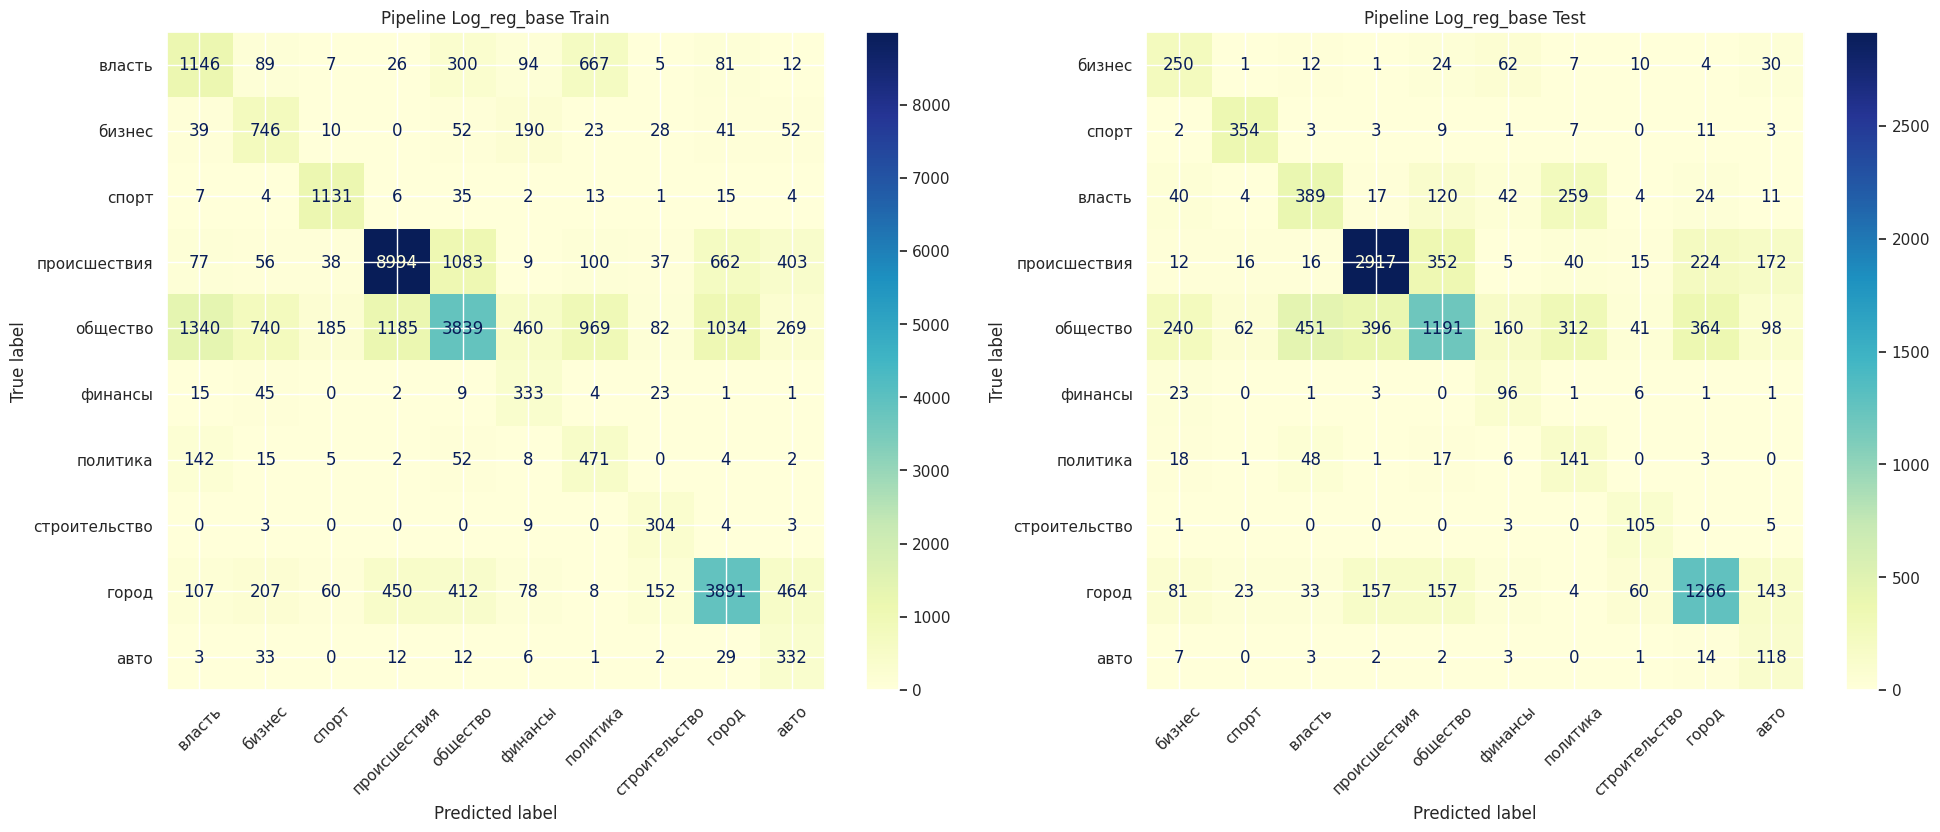

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

plot_confusion_matrix(model=pipe_lr_base,
                      y_true=y_train_num,
                      X=X_train,
                      ax=ax[0],
                      cmap='YlGnBu')
plot_confusion_matrix(model=pipe_lr_base,
                      y_true=y_test_num,
                      X=X_test,
                      ax=ax[1],
                      cmap='YlGnBu')

ax[0].title.set_text(type(pipe_lr_base).__name__ + ' Log_reg_base' + ' Train')
ax[1].title.set_text(type(pipe_lr_base).__name__ + ' Log_reg_base' + ' Test')

for a in ax:
    plt.sca(a)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [21]:
n_classes = len(set(y))
y_test_bin = label_binarize(y_test_num, classes=np.arange(0, 10))

In [22]:
y_score = pipe_lr_base.decision_function(X_test)

metrics = get_metrics_multiclass(y_test_bin=y_test_bin,
                       y_test=y_test_num,
                       y_pred=y_pred_num,
                       y_prob=y_score,
                       name='LogisticRegression_Baseline',
                       type_multi='ovr'
)
metrics

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted
0,LogisticRegression_Baseline,0.885548,0.600545,0.473664,0.600545,0.676945,0.600545,0.518112,0.611158


## SVC

Согласно [документации](https://scikit-learn.org/stable/modules/multiclass.html) NuSVC по умолчанию ovr.

In [23]:
pipe_svc = Pipeline([('selector', CustomSelectColumns(selected_columns_1)),
                 ('preprocessor', CustomTransformer(True,
                                                    txt_feats='content_clean',
                                                    split=True)),
                 ('tfidf', TfidfEmbeddingVectorizer(model,
                                                    column='content_clean')),
                 ('clf', SVC(random_state=RND_STATE,
                             max_iter=10000,
                             class_weight='balanced'
                             ))])

pipe_svc.fit(X_train, y_train_num)

y_pred_num = pipe_svc.predict(X_test)
print(classification_report(y_test_num, y_pred_num, target_names=le.classes_))

               precision    recall  f1-score   support

         авто       0.19      0.75      0.30       150
       бизнес       0.28      0.55      0.37       401
       власть       0.35      0.36      0.36       910
        город       0.64      0.59      0.62      1949
     общество       0.60      0.28      0.38      3315
     политика       0.17      0.65      0.27       235
 происшествия       0.82      0.81      0.81      3769
        спорт       0.89      0.74      0.80       393
строительство       0.42      0.89      0.57       114
      финансы       0.19      0.64      0.29       132

     accuracy                           0.57     11368
    macro avg       0.45      0.63      0.48     11368
 weighted avg       0.64      0.57      0.57     11368



In [24]:
# сохраняем модель в файл
with open('pipe_svc.pkl', 'wb') as file:
    pickle.dump(pipe_svc, file)

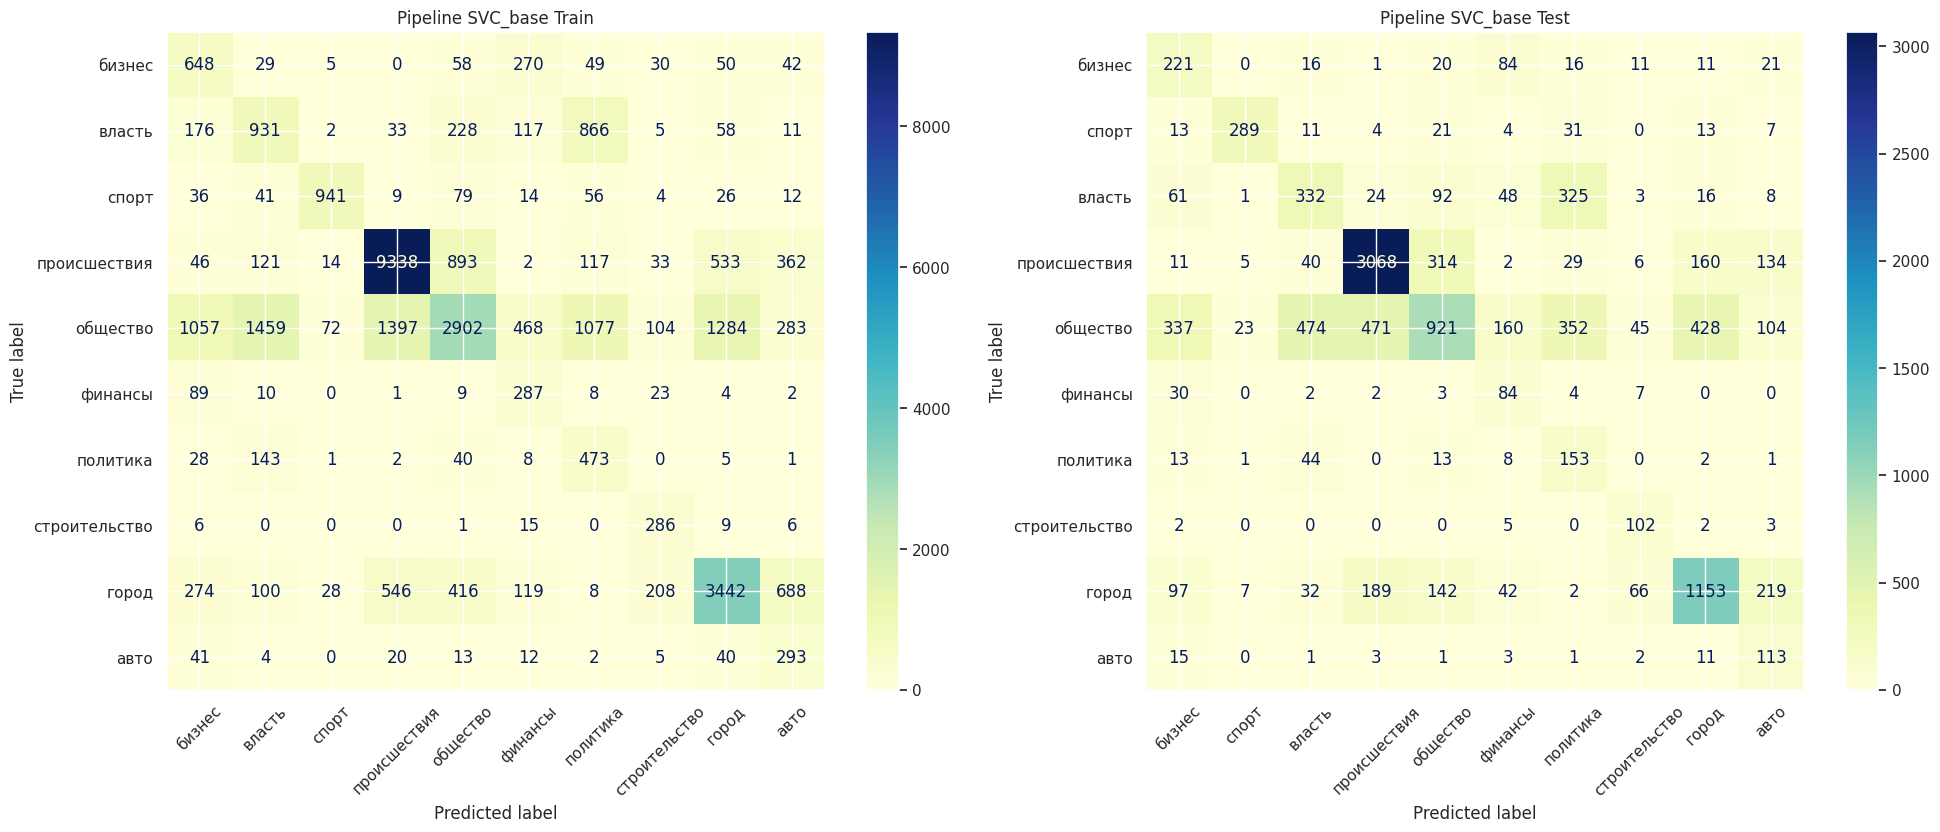

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

plot_confusion_matrix(model=pipe_svc,
                      y_true=y_train_num,
                      X=X_train,
                      ax=ax[0],
                      cmap='YlGnBu')
plot_confusion_matrix(model=pipe_svc,
                      y_true=y_test_num,
                      X=X_test,
                      ax=ax[1],
                      cmap='YlGnBu')

ax[0].title.set_text(type(pipe_svc).__name__ + ' SVC_base' + ' Train')
ax[1].title.set_text(type(pipe_svc).__name__ + ' SVC_base' + ' Test')

for a in ax:
    plt.sca(a)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [26]:
y_score = pipe_svc.decision_function(X_test)

metrics = pd.concat([
    metrics,
    get_metrics_multiclass(y_test_bin=y_test_bin,
                       y_test=y_test_num,
                       y_pred=y_pred_num,
                       y_prob=y_score,
                       name='SVC_Baseline',
                       type_multi='ovr')
])

metrics

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted
0,LogisticRegression_Baseline,0.885548,0.600545,0.473664,0.600545,0.676945,0.600545,0.518112,0.611158
0,SVC_Baseline,0.899367,0.566151,0.453736,0.566151,0.627025,0.566151,0.477013,0.574544


## CatBoost

In [27]:
pipe_catboost = Pipeline([('selector', CustomSelectColumns(selected_columns_1)),
                 ('preprocessor', CustomTransformer(True,
                                                    txt_feats='content_clean',
                                                    split=True)),
                 ('tfidf', TfidfEmbeddingVectorizer(model,
                                                    column='content_clean')),
                 ('clf', CatBoostClassifier(random_state=RND_STATE,
                                            auto_class_weights='Balanced',
                                            loss_function='MultiClass',
                                            verbose=False))])

pipe_catboost.fit(X_train, y_train_num)

y_pred_num = pipe_catboost.predict(X_test)
print(classification_report(y_test_num, y_pred_num, target_names=le.classes_))

               precision    recall  f1-score   support

         авто       0.31      0.61      0.41       150
       бизнес       0.35      0.63      0.45       401
       власть       0.40      0.55      0.46       910
        город       0.68      0.71      0.69      1949
     общество       0.64      0.39      0.48      3315
     политика       0.25      0.39      0.30       235
 происшествия       0.82      0.84      0.83      3769
        спорт       0.78      0.84      0.81       393
строительство       0.68      0.88      0.76       114
      финансы       0.29      0.53      0.38       132

     accuracy                           0.64     11368
    macro avg       0.52      0.64      0.56     11368
 weighted avg       0.66      0.64      0.64     11368



In [28]:
# сохраняем модель в файл
with open('pipe_catboost.pkl', 'wb') as file:
    pickle.dump(pipe_catboost, file)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


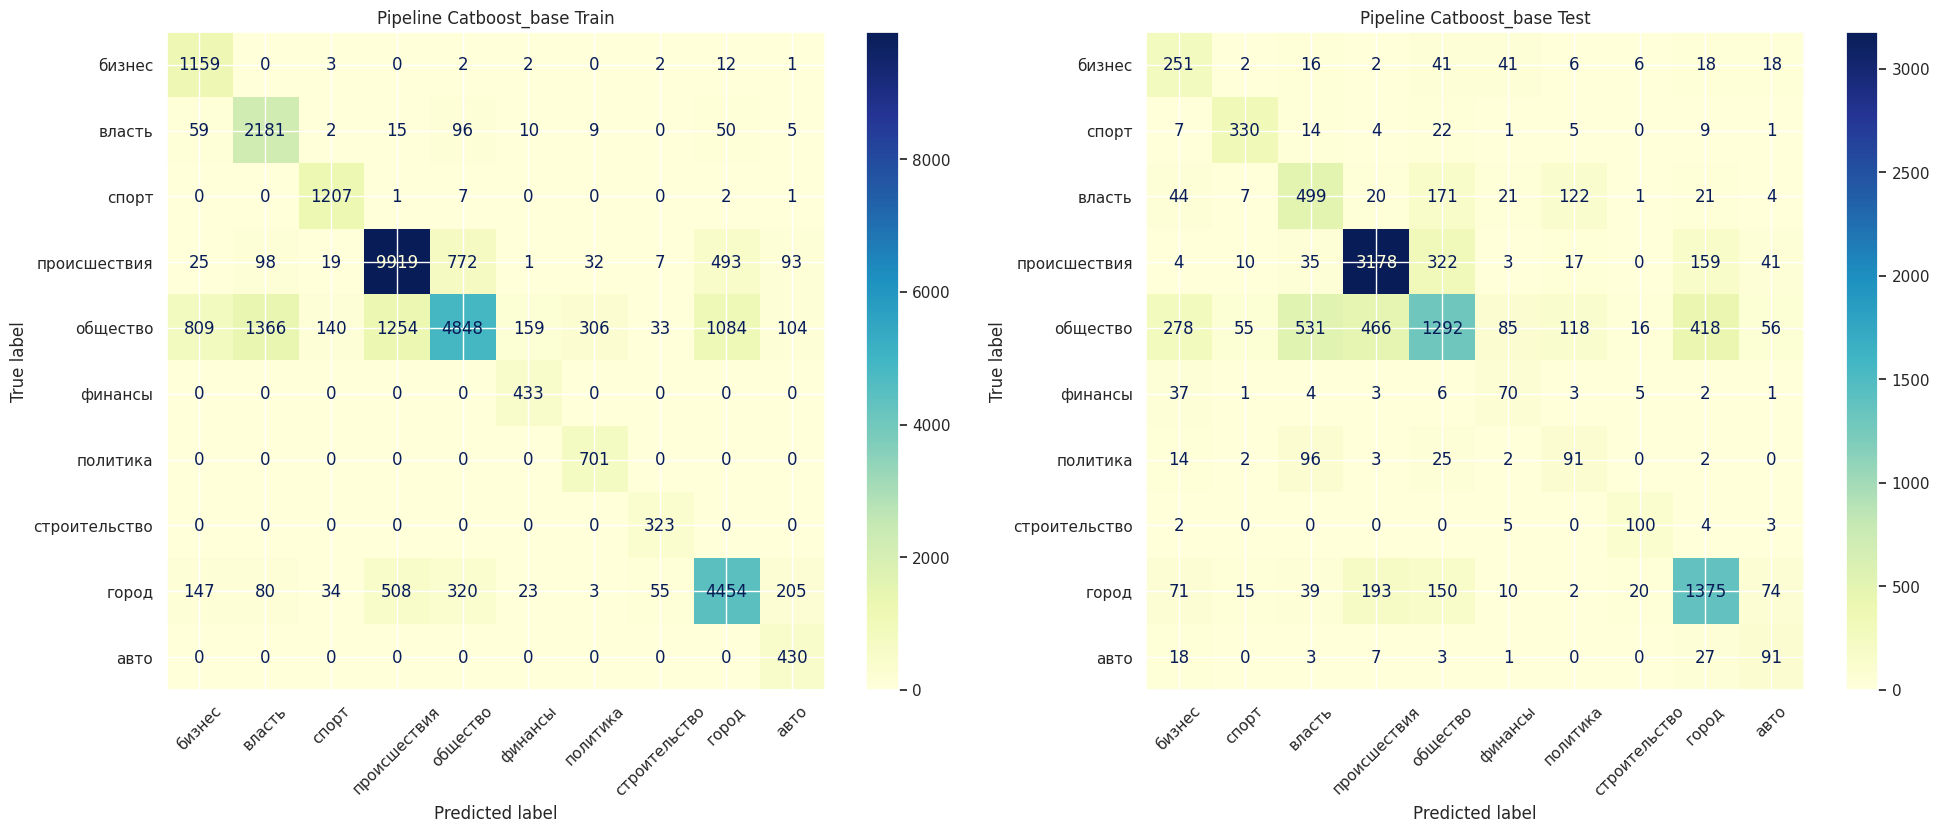

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

plot_confusion_matrix(model=pipe_catboost,
                      y_true=y_train_num,
                      X=X_train,
                      ax=ax[0],
                      cmap='YlGnBu')
plot_confusion_matrix(model=pipe_catboost,
                      y_true=y_test_num,
                      X=X_test,
                      ax=ax[1],
                      cmap='YlGnBu')

ax[0].title.set_text(type(pipe_catboost).__name__ + ' Catboost_base' + ' Train')
ax[1].title.set_text(type(pipe_catboost).__name__ + ' Catboost_base' + ' Test')

for a in ax:
    plt.sca(a)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [30]:
y_score = pipe_catboost.predict_proba(X_test)

metrics = pd.concat([
    metrics,
    get_metrics_multiclass(y_test_bin=y_test_bin,
                       y_test=y_test_num,
                       y_pred=y_pred_num,
                       y_prob=y_score,
                       name='Catboost_Baseline',
                       type_multi='ovr')
])

metrics

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted
0,LogisticRegression_Baseline,0.885548,0.600545,0.473664,0.600545,0.676945,0.600545,0.518112,0.611158
0,SVC_Baseline,0.899367,0.566151,0.453736,0.566151,0.627025,0.566151,0.477013,0.574544
0,Catboost_Baseline,0.936141,0.640130,0.519598,0.640130,0.635381,0.640130,0.558413,0.639616


## CatBoost text features

Попробуем использовать внутреннюю обработку текстовых признаков CatBoost. Для этого передадим тексты статей напрямую без токенизации в нашу модель.

In [31]:
selected_coumns_2 = ['comments_amount',
       'year',
       'month',
       'weekday',
       'hour',
       'log_views',
       'len_title',
       'len_content',
       'log_views_by_minutes',
       'content']

In [32]:
pipe_catboost_txt = Pipeline([('selector',
                               CustomSelectColumns(selected_coumns_2)),
                              ('preprocessor',
                              CustomTransformer(True,
                                                txt_feats='content',
                                                split=False)),
                              ('clf', CatBoostClassifier(random_state=RND_STATE,
                                            auto_class_weights='Balanced',
                                            text_features = ['content'],
                                            loss_function='MultiClass',
                                            verbose=False))
                 ])

pipe_catboost_txt.fit(X_train, y_train_num)

y_pred_num = pipe_catboost_txt.predict(X_test)
print(classification_report(y_test_num, y_pred_num, target_names=le.classes_))

               precision    recall  f1-score   support

         авто       0.40      0.83      0.54       150
       бизнес       0.42      0.72      0.53       401
       власть       0.45      0.63      0.53       910
        город       0.73      0.74      0.73      1949
     общество       0.71      0.41      0.52      3315
     политика       0.29      0.63      0.39       235
 происшествия       0.85      0.86      0.85      3769
        спорт       0.82      0.95      0.88       393
строительство       0.89      0.96      0.92       114
      финансы       0.35      0.80      0.49       132

     accuracy                           0.68     11368
    macro avg       0.59      0.75      0.64     11368
 weighted avg       0.72      0.68      0.68     11368



In [33]:
# сохраняем модель в файл
with open('pipe_catboost_txt.pkl', 'wb') as file:
    pickle.dump(pipe_catboost_txt, file)

In [34]:
y_score = pipe_catboost_txt.predict_proba(X_test)

metrics = pd.concat([
    metrics,
    get_metrics_multiclass(y_test_bin=y_test_bin,
                       y_test=y_test_num,
                       y_pred=y_pred_num,
                       y_prob=y_score,
                       name='Catboost_txt_Baseline',
                       type_multi='ovr')
])

metrics

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted
0,LogisticRegression_Baseline,0.885548,0.600545,0.473664,0.600545,0.676945,0.600545,0.518112,0.611158
0,SVC_Baseline,0.899367,0.566151,0.453736,0.566151,0.627025,0.566151,0.477013,0.574544
0,Catboost_Baseline,0.936141,0.640130,0.519598,0.640130,0.635381,0.640130,0.558413,0.639616
0,Catboost_txt_Baseline,0.950844,0.681738,0.591457,0.681738,0.752221,0.681738,0.639341,0.680588


## Multilabel

Попробуем использовать метаклассы на примере логистической регрессии.

Можем также работать через пайплайн, но попытаемся уменьшить время работы и сначала просто предобработаем наш датасет.

In [36]:
preprocessor = Pipeline([('selector', CustomSelectColumns(selected_columns_1)),
                         ('preprocessor',
                          CustomTransformer(True,
                                            txt_feats='content_clean',
                                            split=True)),
                         ('tfidf',
                          TfidfEmbeddingVectorizer(model,
                                                   column='content_clean'))])

X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

### One vs One

#### Логистическая регрессия

In [37]:
clf = LogisticRegression(random_state=RND_STATE,
                         max_iter=10000,
                         class_weight='balanced')

ovo = OneVsOneClassifier(clf)
ovo.fit(X_train_preprocessed, y_train_num)

y_pred_num = ovo.predict(X_test_preprocessed)
print(classification_report(y_test_num, y_pred_num, target_names=le.classes_))

               precision    recall  f1-score   support

         авто       0.22      0.75      0.34       150
       бизнес       0.38      0.60      0.46       401
       власть       0.41      0.44      0.42       910
        город       0.67      0.67      0.67      1949
     общество       0.65      0.38      0.48      3315
     политика       0.18      0.60      0.28       235
 происшествия       0.84      0.80      0.82      3769
        спорт       0.80      0.89      0.84       393
строительство       0.49      0.91      0.64       114
      финансы       0.23      0.68      0.35       132

     accuracy                           0.61     11368
    macro avg       0.49      0.67      0.53     11368
 weighted avg       0.67      0.61      0.62     11368



In [39]:
# сохраняем модель в файл
with open('ovo_lr.pkl', 'wb') as file:
    pickle.dump(ovo, file)

In [40]:
y_pred_num = ovo.predict(X_test_preprocessed)
y_score = ovo.decision_function(X_test_preprocessed)

metrics = pd.concat([
    metrics,
    get_metrics_multiclass(y_test_bin=y_test_bin,
                       y_test=y_test_num,
                       y_pred=y_pred_num,
                       y_prob=y_score,
                       name='OVO_LogReg_Baseline',
                       type_multi='ovo')
])

metrics

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted
0,LogisticRegression_Baseline,0.885548,0.600545,0.473664,0.600545,0.676945,0.600545,0.518112,0.611158
0,SVC_Baseline,0.899367,0.566151,0.453736,0.566151,0.627025,0.566151,0.477013,0.574544
0,Catboost_Baseline,0.936141,0.640130,0.519598,0.640130,0.635381,0.640130,0.558413,0.639616
0,Catboost_txt_Baseline,0.950844,0.681738,0.591457,0.681738,0.752221,0.681738,0.639341,0.680588
0,OVO_LogReg_Baseline,0.916169,0.614444,0.487041,0.614444,0.669893,0.614444,0.529468,0.624489


### One vs Rest

#### Логистическая регрессия

In [41]:
clf = LogisticRegression(random_state=RND_STATE,
                         max_iter=10000,
                         class_weight='balanced')

ovr = OneVsRestClassifier(clf)
ovr.fit(X_train_preprocessed, y_train_num)

OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=10000,
                                                 random_state=7575))

In [42]:
# сохраняем модель в файл
with open('ovr_lr.pkl', 'wb') as file:
    pickle.dump(ovr, file)

In [43]:
y_pred_num = ovr.predict(X_test_preprocessed)
y_score = ovr.decision_function(X_test_preprocessed)

metrics = pd.concat([
    metrics,
    get_metrics_multiclass(y_test_bin=y_test_bin,
                       y_test=y_test_num,
                       y_pred=y_pred_num,
                       y_prob=y_score,
                       name='OVR_LogReg_Baseline',
                       type_multi='ovr')
])

# metrics

#### RandomForestClassifier

In [45]:
clf = RandomForestClassifier(random_state=RND_STATE,
                         class_weight='balanced')

ovr = OneVsRestClassifier(clf)
ovr.fit(X_train_preprocessed, y_train_num)

OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                     random_state=7575))

In [46]:
# сохраняем модель в файл
with open('ovr_rf.pkl', 'wb') as file:
    pickle.dump(ovr, file)

In [47]:
y_pred_num = ovr.predict(X_test_preprocessed)
y_score = ovr.predict_proba(X_test_preprocessed)

metrics = pd.concat([
    metrics,
    get_metrics_multiclass(y_test_bin=y_test_bin,
                       y_test=y_test_num,
                       y_pred=y_pred_num,
                       y_prob=y_score,
                       name='OVR_RandomForest_Baseline',
                       type_multi='ovr')
])

In [48]:
metrics.to_csv('metrics.csv', index=False)

In [49]:
metrics

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted
0,LogisticRegression_Baseline,0.885548,0.600545,0.473664,0.600545,0.676945,0.600545,0.518112,0.611158
0,SVC_Baseline,0.899367,0.566151,0.453736,0.566151,0.627025,0.566151,0.477013,0.574544
0,Catboost_Baseline,0.936141,0.640130,0.519598,0.640130,0.635381,0.640130,0.558413,0.639616
0,Catboost_txt_Baseline,0.950844,0.681738,0.591457,0.681738,0.752221,0.681738,0.639341,0.680588
0,OVO_LogReg_Baseline,0.916169,0.614444,0.487041,0.614444,0.669893,0.614444,0.529468,0.624489
0,OVR_LogReg_Baseline,0.941273,0.645144,0.506047,0.645144,0.659763,0.645144,0.552695,0.649337
0,OVR_RandomForest_Baseline,0.922504,0.665289,0.632575,0.665289,0.452733,0.665289,0.500665,0.650245


In [50]:
metrics.sort_values("F1_weighted", ascending=False)

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted
0,Catboost_txt_Baseline,0.950844,0.681738,0.591457,0.681738,0.752221,0.681738,0.639341,0.680588
0,OVR_RandomForest_Baseline,0.922504,0.665289,0.632575,0.665289,0.452733,0.665289,0.500665,0.650245
0,OVR_LogReg_Baseline,0.941273,0.645144,0.506047,0.645144,0.659763,0.645144,0.552695,0.649337
0,Catboost_Baseline,0.936141,0.640130,0.519598,0.640130,0.635381,0.640130,0.558413,0.639616
0,OVO_LogReg_Baseline,0.916169,0.614444,0.487041,0.614444,0.669893,0.614444,0.529468,0.624489
0,LogisticRegression_Baseline,0.885548,0.600545,0.473664,0.600545,0.676945,0.600545,0.518112,0.611158
0,SVC_Baseline,0.899367,0.566151,0.453736,0.566151,0.627025,0.566151,0.477013,0.574544


In [ ]:
metrics = metrics.reset_index(drop=True)
metrics = metrics.set_index("model")
metrics = metrics.sort_values("F1_weighted", ascending=False)

def highlight_max(s):
    is_max = s == s.max()
    return ["background-color: yellow" if v else "" for v in is_max]

styled_metrics = metrics.style.apply(highlight_max, subset=["F1_weighted"])

styled_metrics

,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted,Logloss
model,,,,,,,,,
Catboost_txt_Baseline,0.951006,0.680771,0.589401,0.680771,0.746439,0.680771,0.636589,0.680328,0.854864
OVR_LogReg_Baseline,0.941255,0.644880,0.505869,0.644880,0.659735,0.644880,0.552509,0.649067,5.421575
Catboost_Baseline,0.936334,0.639163,0.520739,0.639163,0.636953,0.639163,0.559555,0.638240,0.925598
OVR_RandomForest_Baseline,0.922881,0.664761,0.625818,0.664761,0.454295,0.664761,0.500995,0.649707,1.151480
OVO_LogReg_Baseline,0.916209,0.614620,0.487139,0.614620,0.669870,0.614620,0.529497,0.624681,2.183485
SVC_Baseline,0.899350,0.566327,0.453826,0.566327,0.626822,0.566327,0.476960,0.574767,2.180654
LogisticRegresstion_Baseline,0.885518,0.600545,0.473496,0.600545,0.676802,0.600545,0.517959,0.611120,1.787299


## RuBert

In [ ]:
import warnings
import re

import torch
import gc

from tqdm.auto import tqdm


import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AdamW
from transformers import BertForSequenceClassification
from transformers import pipeline
from transformers import Trainer
from transformers import AutoTokenizer
from transformers import TrainingArguments

from scipy.special import softmax

import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

warnings.filterwarnings('ignore')

### Загрузка данных и токенизация

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader


class PrepareDataset:
    def __init__(self, texts, tokenizer, batch_size_split=10, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.batch_size_split = batch_size_split

    def pre_tokenizer(self, data):
        return self.tokenizer(data,
                              padding='max_length', # заполняем до максимальной
                              truncation=True, # обрезаем
                              return_tensors='pt', # pytorch
                              max_length=self.max_length)

    def transform(self):
        N = len(self.texts)
        size_split = N // self.batch_size_split

        train_encodings = self.pre_tokenizer(self.texts[:size_split])
        input_ids = train_encodings['input_ids']
        attention_mask = train_encodings['attention_mask']
        token_type_ids = train_encodings['token_type_ids']

        for pos in tqdm(range(size_split, N, size_split)):
            train_encodings_2 = self.pre_tokenizer(self.texts[pos:pos +
                                                              size_split])
            input_ids = torch.cat((input_ids, train_encodings_2['input_ids']))
            attention_mask = torch.cat(
                (attention_mask, train_encodings_2['attention_mask']))
            token_type_ids = torch.cat(
                (token_type_ids, train_encodings_2['token_type_ids']))

        return {
            'input_ids': input_ids,
            'token_type_ids': token_type_ids,
            'attention_mask': attention_mask
        }

In [ ]:
# dtype_dict = {
#     'subcategory': 'category',
#     'category': 'category',
#     'price': 'float32',
#     'region': 'category',
#     'city': 'category',
#     'is_bad': 'bool'
# }

# train = pd.read_csv('/content/gdrive/MyDrive/test/data/train.csv',
#                     dtype=dtype_dict)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2", do_lower_case=True)

In [ ]:
%%time
max_length = 512

clf = PrepareDataset(texts=X_train.content.tolist(),
                     tokenizer=tokenizer,
                     batch_size_split=15)
X_train_encodings = clf.transform()

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 1min, sys: 3.06 s, total: 1min 3s
Wall time: 1min 2s


In [ ]:
clf = PrepareDataset(texts = X_test.content.tolist(), tokenizer=tokenizer)
X_test_encodings = clf.transform()

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
gc.collect()

38

In [ ]:
# class GroupsDataset(torch.utils.data.Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         self.labels = labels

#     def __getitem__(self, idx):
#         item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}

#         item["labels"] = torch.tensor([self.labels[idx]])
#         return item

#     def __len__(self):
#         return len(self.labels)

# class GroupsDataset(torch.utils.data.Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         self.labels = labels

#     def __getitem__(self, idx):
#         item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
#         item["labels"] = torch.tensor(self.labels[idx])
#         return item

#     def __len__(self):
#         return len(self.labels)


class GroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = GroupsDataset(X_train_encodings, y_train_num.tolist())
test_dataset = GroupsDataset(X_test_encodings, y_test_num.tolist())

In [ ]:
model = BertForSequenceClassification.from_pretrained('cointegrated/rubert-tiny2', num_labels=10)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Обучение модели bert-tiny2



Заморозим все слои, кроме последних шести

In [ ]:
bert_model = model.bert
bert_layers = list(bert_model.encoder.layer)

for i, layer in enumerate(bert_layers):
    if i < len(bert_layers) - 6:
        for param in layer.parameters():
            param.requires_grad = False
    else:
        break

bert_model.encoder.layer = torch.nn.ModuleList(bert_layers)

In [ ]:
# for param in model.bert.parameters():
#     param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-

In [ ]:
def compute_metrics(eval_preds):
    """Расчет метрики f1"""

    metric = evaluate.load("f1", "multilabel")
    logits, labels = eval_preds
    # predictions = softmax(logits)[:, 1]
    predictions = torch.argmax(logits, dim=-1)
    res = metric.compute(prediction_scores=predictions, references=labels, average="weighted" )
    f1_weighted = f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='weighted')

    return {'f1': res['f1']}#{'f1_weighted': f1_weighted}

In [ ]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = torch.argmax(logits, dim=-1)
    f1_weighted = f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='weighted')
    return {'f1_weighted': f1_weighted}

In [ ]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    logits = torch.tensor(logits)
    predictions = torch.argmax(logits, dim=-1)
    f1_weighted = f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='weighted')
    return {'f1_weighted': f1_weighted}

In [ ]:
# %pip install transformers -q
# !pip install pytorch-transformers

In [ ]:
# !pip uninstall transformers accelerate -y  -q
# !pip install transformers[torch] -q
# !pip install accelerate -U -q

In [ ]:
!pip show transformers
!pip show accelerate

Name: transformers
Version: 4.41.0
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 
Name: accelerate
Version: 0.30.1
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [ ]:
args = TrainingArguments("bert_class_tiny2",
                         evaluation_strategy="epoch",
                         save_strategy="no",
                         learning_rate=2e-5,
                         num_train_epochs=10,
                         weight_decay=0.01,
                         push_to_hub=False,
                         per_device_train_batch_size=64)

In [ ]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    logits = torch.tensor(logits)
    predictions = torch.argmax(logits, dim=-1)
    f1_weighted = f1_score(labels, predictions, average='weighted')
    return {'f1_weighted': f1_weighted}


In [ ]:
# Изменение: обновить параметр compute_metrics в Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model("bert_class_tiny2")

Epoch,Training Loss,Validation Loss,F1 Weighted
1,0.488700,0.814150,0.709285
2,0.574700,0.753330,0.718998
3,0.545200,0.767965,0.716266
4,0.499800,0.772966,0.717863
5,0.465300,0.791542,0.716891
6,0.434900,0.809446,0.713679
7,0.409900,0.828590,0.712417


Epoch,Training Loss,Validation Loss,F1 Weighted
1,0.488700,0.814150,0.709285
2,0.574700,0.753330,0.718998
3,0.545200,0.767965,0.716266
4,0.499800,0.772966,0.717863
5,0.465300,0.791542,0.716891
6,0.434900,0.809446,0.713679
7,0.409900,0.828590,0.712417
8,0.394000,0.839257,0.712096
9,0.374300,0.845631,0.712677
10,0.359800,0.849531,0.711386


In [ ]:
model_path = "bert_class_tiny2"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('bert_class_tiny2/tokenizer_config.json',
 'bert_class_tiny2/special_tokens_map.json',
 'bert_class_tiny2/vocab.txt',
 'bert_class_tiny2/added_tokens.json',
 'bert_class_tiny2/tokenizer.json')

In [ ]:
def predict_proba(text: str, pipeline) -> List[float]:
    """Получение вероятности контакта в тексте"""
    predict = pipeline(text)[0]
    return predict["score"]


def task(description: pd.Series) -> pd.DataFrame:
    """Получение результатов прогноза """
    clf = pipe("text-classification", model=model_path, device=device)
    dataset_pbar = tqdm(description)
    result = [predict_proba(data, clf) for data in dataset_pbar]
    return pd.DataFrame(result, index=description.index, columns=[0:10])

# **Выводы:**
- Будем смотреть на метрику F1_weighted. У нас нет предпочтений насчёт точности или полноты классификации статей. Но при этом у нас дисбаланс классов. Хотим учитывать важность класса, в зависимости от количества объектов данного класса.
- По этой метрике у нас лучше всего отработал вариант базового Catboost с внутренней обработкой текстовых признаков.
- Также достаточно неплохо себя проявила логистическая регрессия с использованием метамодели OVR. При этом логистическая регрессия без метамодели показала худший результат для данной задачи. Также следует отметить, что если не балансировать классы, то логистическая регрессия без метамодели улучшала значения.
- Необходимо отметить, что в данном варианте векторизировал слова при помощи word2vec, но тестировал fasttext. Это изменяло результаты (особенно в других метриках, например, ROC_AUC), но сама модель fasttext получалась очень большой по объёму и не подходила для улучшений, т.к. происходил вылет по оперативной памяти. Возможно следовало поменять схему построения векторов предложений.
- Также можно было попробовать векторизировать слова продвинутыми моделями